In [4]:
!pip install torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
data = pd.read_csv("/content/sample_data/amazon_cells_labelled.txt", sep="\t", \
                   header=None)
reviews = data.iloc[:,0].str.lower()
sentiment = data.iloc[:,1].values

In [7]:
for i in punctuation:
    reviews = reviews.str.replace(i,"")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [8]:
words = ' '.join(reviews)
words = words.split()
vocabulary = set(words)
indexer = {word: index for (index, word) \
           in enumerate(vocabulary)}

In [9]:
indexed_reviews = []
for review in reviews:
    indexed_reviews.append([indexer[word] \
                            for word in review.split()])

In [10]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, \
                 hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, \
                            n_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.output(out)
        out = out[-1,0]
        out = torch.sigmoid(out).unsqueeze(0)
        return out

In [11]:
model = LSTM(len(vocabulary), 64, 128, 3)
model

LSTM(
  (embedding): Embedding(1905, 64)
  (lstm): LSTM(64, 128, num_layers=3, batch_first=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)

In [12]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [20]:
# def accuracy(preds, y):
#     _, preds = torch.max(preds, dim= 1)
#     acc = torch.sum(preds == y) / len(y)
#     return acc

In [27]:
losses = []
acc = []
for e in range(1, epochs+1):
    single_loss = []
    preds = []
    targets = []
    for i, r in enumerate(indexed_reviews):
        if len(r) <= 1:
            continue
        x = torch.Tensor([r]).long()
        y = torch.Tensor([sentiment[i]])
        pred = model(x)
        loss = loss_function(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        final_pred = np.round(pred.detach().numpy())
        preds.append(np.round(final_pred))
        targets.append(y)
        single_loss.append(loss.item())
    losses.append(np.mean(single_loss))
    # # # accuracy = np.sum(np.multiply(acc , batch_len))
    # # #                     / np.sum(batch_len)
    # # accuracy = accuracy_score(targets, np.argmax(preds, axis=1))
    # acc.append(accuracy)
    if e%1 == 0:
        print("Epoch: ", e, "... Loss function: ", losses[-1])
              # "... Accuracy: ", acc[-1])



Epoch:  1 ... Loss function:  0.05602908100707033
Epoch:  2 ... Loss function:  0.04216817257582361
Epoch:  3 ... Loss function:  0.05084665056137068
Epoch:  4 ... Loss function:  0.05847308760760933
Epoch:  5 ... Loss function:  0.02320236219076807
Epoch:  6 ... Loss function:  0.022527413898137044
Epoch:  7 ... Loss function:  0.008752314288449818
Epoch:  8 ... Loss function:  0.007555616034977732
Epoch:  9 ... Loss function:  0.00694973214056781
Epoch:  10 ... Loss function:  0.024229578004420358


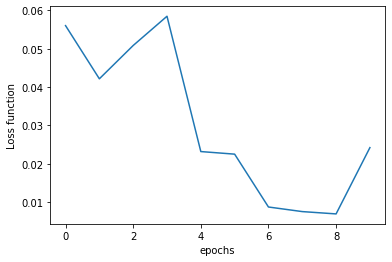

In [28]:
x_range = range(len(losses))
plt.plot(x_range, losses)
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.show()

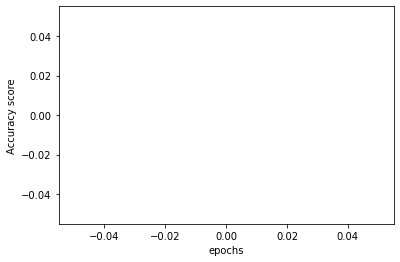

In [29]:
x_range = range(len(acc))
plt.plot(x_range, acc)
plt.xlabel("epochs")
plt.ylabel("Accuracy score")
plt.show()

###Reference: https://www.google.com/books/edition/The_The_Deep_Learning_with_PyTorch_Works/dsTyDwAAQBAJ?hl=en&gbpv=1&dq=inauthor:%22Hyatt+Saleh%22&printsec=frontcover